# Basic exploration

Yannik Schaelte

Some data exploration and a simple ResNet-50 model with re-trained linear last layer.
Neither the pre-processing nor the model are good, this is just for tests.

## Load data

In [52]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import random
import os

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms

# Convenience functions
id2loc = lambda id_: f'data/img_{id_}.png'
id2img = lambda id_: Image.open(id2loc(id_))
img2arr = lambda img: np.array(img)
id2arr = lambda id_: img2arr(id2img(id_))

imgt2img = lambda imgt: transforms.ToPILImage()(imgt)
imgt2arr = lambda imgt: img2arr(imgt2img(imgt))

# Load labels
labels = pd.read_csv('data/labels.csv', sep=',')
# Convert to >= 0
labels["malignant"] += 1

label2text = {
    0: 'negative',
    1: 'benign',
    2: 'malignant'
}
text2label = {v: k for k, v in label2text.items()}

labels.head(10)

id  malignant
0     441          0
1   33284          0
2   38771          2
3   46784          0
4   57613          0
5   74682          1
6   78884          1
7   93760          1
8   98327          1
9  112905          1

In [50]:
labels_negative = labels[labels["malignant"]==0]
labels_benign = labels[labels["malignant"]==1]
labels_malignant = labels[labels["malignant"]==2]

## Explore

In [51]:
print("Number of negative labels: ", len(labels_negative))
print("Number of benign labels: ", len(labels_benign))
print("Number of malignant labels: ", len(labels_malignant))
print("Total number of labels: ", len(labels))

Number of negative labels:  36
Number of benign labels:  14
Number of malignant labels:  12
Total number of labels:  62


Let's plot some images from all classes:

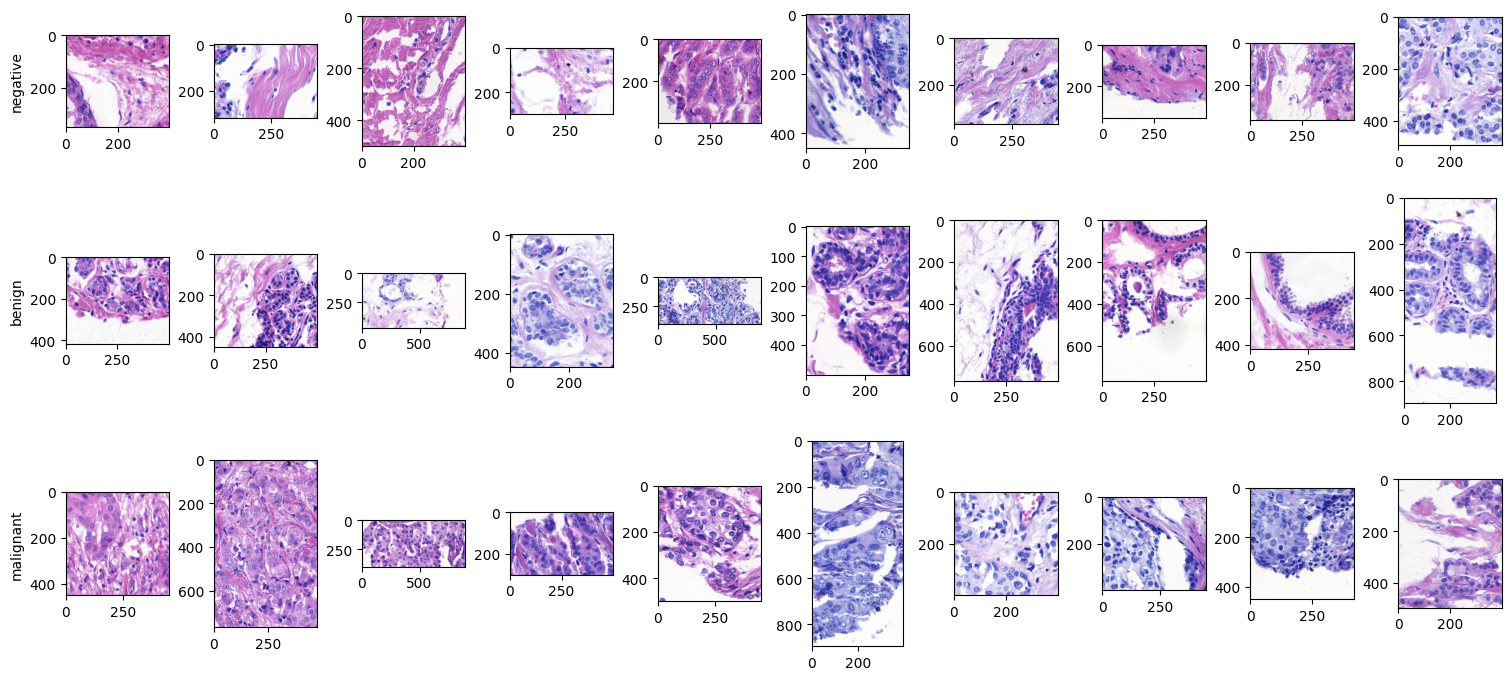

In [53]:
n_fig = 10
fig, axes = plt.subplots(3, n_fig, figsize=(15, 7), constrained_layout=True)

for i in range(n_fig):
    axes[0, i].imshow(id2arr(labels_negative.iloc[i]["id"]))
    axes[1, i].imshow(id2arr(labels_benign.iloc[i]["id"]))
    axes[2, i].imshow(id2arr(labels_malignant.iloc[i]["id"]))
for key, val in label2text.items():
    axes[key, 0].set_ylabel(val);

Let's inspect some in more detail:

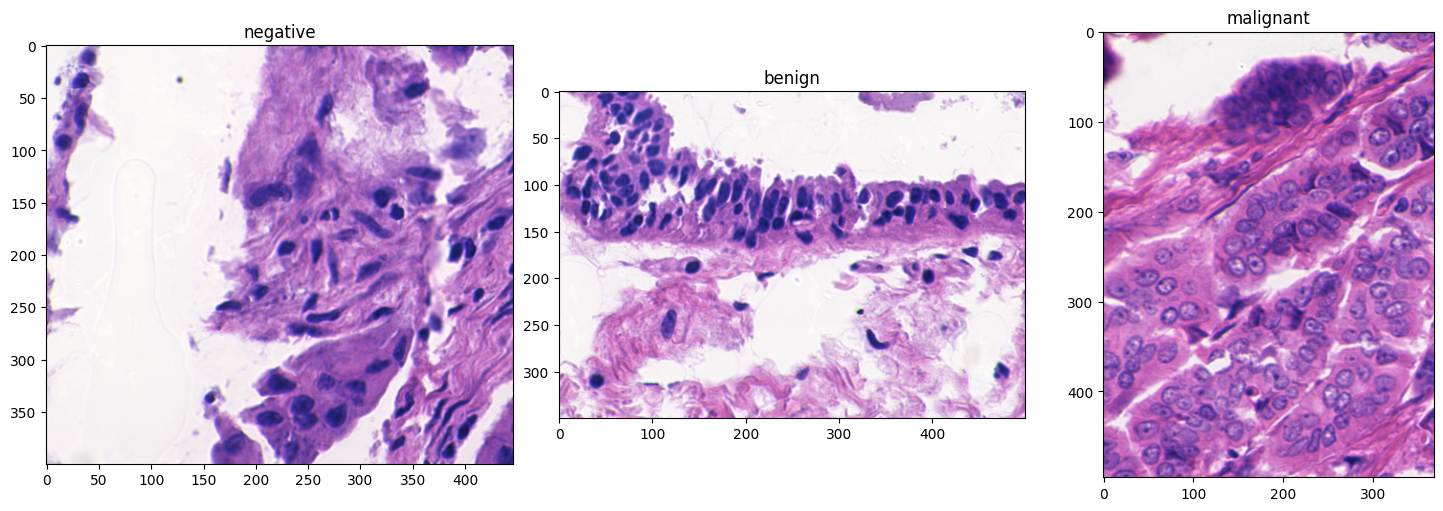

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].imshow(id2arr(labels_negative.iloc[11]["id"]))
axes[1].imshow(id2arr(labels_benign.iloc[11]["id"]))
axes[2].imshow(id2arr(labels_malignant.iloc[11]["id"]))
for key, val in label2text.items():
    axes[key].set_title(val);

Of note is the heterogeneity of image sizes and shapes. Let's inspect that further:

In [6]:
dims = [id2arr(labels.iloc[i]["id"]).shape for i in range(len(labels))]
dims = pd.DataFrame(dims, columns=["width", "height", "channels"])
dims.describe()

width      height  channels
count   62.000000   62.000000      62.0
mean   469.548387  464.516129       3.0
std    149.680937  144.946428       0.0
min    268.000000  300.000000       3.0
25%    368.000000  400.000000       3.0
50%    446.000000  419.500000       3.0
75%    496.000000  490.750000       3.0
max    896.000000  896.000000       3.0

In [7]:
# maximum width or height
max_dim = max(dims["width"].max(), dims["height"].max())
max_dim

896

## Preprocessing

In [10]:
# apply ResNet50 transformations
transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()

# Should be equivalent to:
# transform = transforms.Compose(
#     [
#         transforms.Resize(
#             256,
#             interpolation=transforms.InterpolationMode.BILINEAR,
#         ),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
#     ],
# )

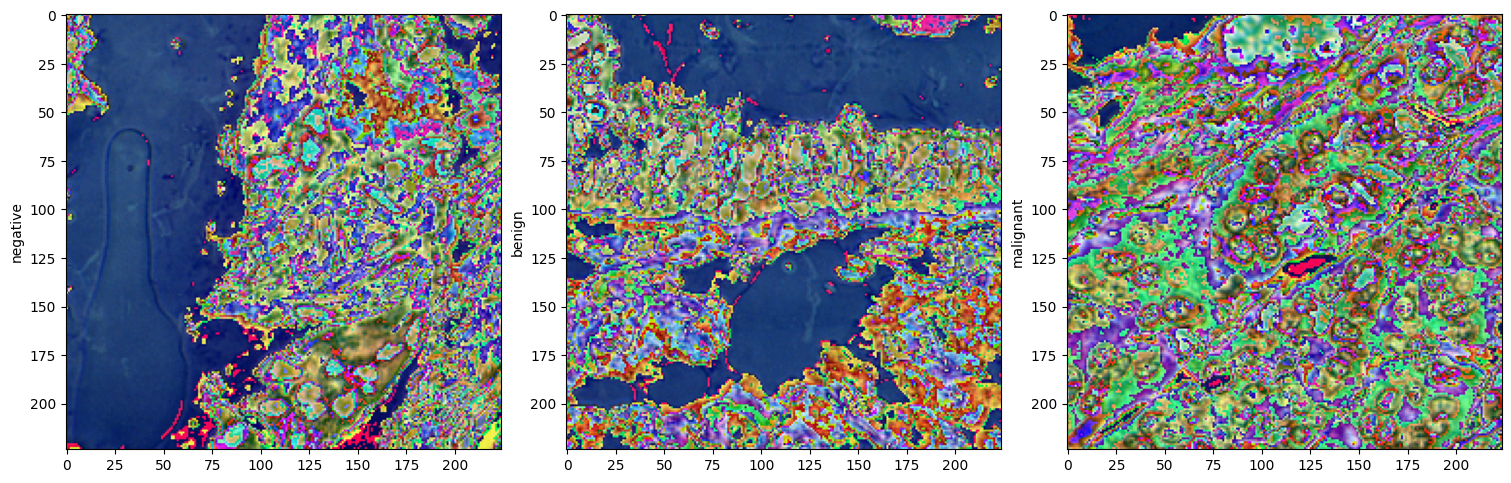

In [36]:
# Visualize transformed images

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].imshow(imgt2arr(transform(id2img(labels_negative.iloc[11]["id"]))))
axes[1].imshow(imgt2arr(transform(id2img(labels_benign.iloc[11]["id"]))))
axes[2].imshow(imgt2arr(transform(id2img(labels_malignant.iloc[11]["id"]))))
for key, val in label2text.items():
    axes[key].set_ylabel(val);

In [12]:
class CarcinomaDataset(Dataset):
    def __init__(self, labels, transform=None, target_transform=None, id2img=None):
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        if id2img is None:
            id2loc = lambda id_: f'data/img_{id_}.png'
            id2img = lambda id_: Image.open(id2loc(id_))
        self.id2img = id2img

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        id_, label = self.labels.iloc[idx][["id", "malignant"]]
        img = self.id2img(id_)
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label
    
# Create the dataset
dataset = CarcinomaDataset(labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

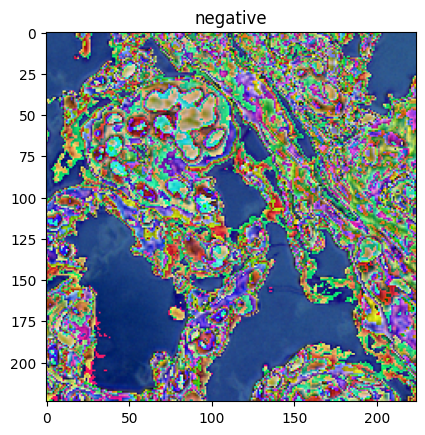

In [13]:
# test dataloader

_imgs, _labels = next(iter(dataloader))
plt.imshow(imgt2arr(_imgs[0]))
plt.title(label2text[int(_labels[0])]);

## Fine-tune Pre-trained ResNet50 model

In [14]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
device

device(type='cpu')

In [18]:
# Load model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the lat fully connected layer
# Number of inputs for linear layer
num_features = model.fc.in_features
num_classes = 3
model.fc = nn.Linear(num_features, num_classes)

# Move model to device
model = model.to(device)

# Define loss function
loss = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train function
def train(model, dataloader, loss, optimizer, device, num_epochs=25):
    # Set model to training mode
    model.train()
    for epoch in range(num_epochs):
        for _imgs, _labels in dataloader:
            # Move data to device
            _imgs = _imgs.to(device)
            _labels = _labels.to(device)
            # Zero the gradients (otherwise they are accumulated)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(_imgs)
            # Compute loss
            loss_value = loss(outputs, _labels)
            # Backward pass
            loss_value.backward()
            # Update parameters
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs} loss: {loss_value:.4f}")

In [19]:
torch.manual_seed(0)

# Train the model
train(model, dataloader, loss, optimizer, device)

Epoch 1/25 loss: 0.9915
Epoch 2/25 loss: 0.9050
Epoch 3/25 loss: 0.8924
Epoch 4/25 loss: 0.7939
Epoch 5/25 loss: 0.8606
Epoch 6/25 loss: 0.8432
Epoch 7/25 loss: 0.8407
Epoch 8/25 loss: 0.7951
Epoch 9/25 loss: 0.6098
Epoch 10/25 loss: 0.6278
Epoch 11/25 loss: 0.5951
Epoch 12/25 loss: 0.5920
Epoch 13/25 loss: 0.6192
Epoch 14/25 loss: 0.5690
Epoch 15/25 loss: 0.5479
Epoch 16/25 loss: 0.5175
Epoch 17/25 loss: 0.4294
Epoch 18/25 loss: 0.5139
Epoch 19/25 loss: 0.4400
Epoch 20/25 loss: 0.5225
Epoch 21/25 loss: 0.4534
Epoch 22/25 loss: 0.3824
Epoch 23/25 loss: 0.3386
Epoch 24/25 loss: 0.3321
Epoch 25/25 loss: 0.3196


In [20]:
# Number of parameters
print("Number of parameters:", sum(p.numel() for p in model.parameters()))
print("Number of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of parameters: 23514179
Number of trainable parameters: 6147


## Predict

In [54]:
# Gather test set
# The validation set is the set of images that are not contained in labels.to_csv

training_ids = set(labels["id"])
test_ids = []
# Iterate through PNG files in data directory
for file in os.listdir("data"):
    # Check if file is a PNG file
    if file.endswith(".png"):
        # Extract id
        id_ = int(file[4:-4])
        # Check if id is in training set
        if id_ not in training_ids:
            test_ids.append(id_)

assert len(test_ids) + len(labels) == 186

In [59]:
# Set model to evaluation mode
model.eval()

# Predict labels on test set
test_labels = []
for id_ in test_ids:
    # Load image
    img = id2img(id_)
    # Apply transformations
    img = transform(img)
    # Add batch dimension
    img = img.unsqueeze(0)
    # Move to device
    img = img.to(device)
    # Predict
    label = torch.argmax(model(img)).item()
    # Save label
    test_labels.append(label)

# Create dataframe from ids and labels
test_labels = pd.DataFrame({"id": test_ids, "malignant": test_labels})
# Sort
test_labels.sort_values(by="id", inplace=True)
test_labels

id  malignant
86    5042          0
53   28148          0
95   35946          0
89   37944          0
29   39157          1
..     ...        ...
71  959476          0
13  968389          0
80  976505          0
5   996288          2
41  997841          1

[124 rows x 2 columns]

In [60]:
print("Number of negative labels: ", len(test_labels[test_labels["malignant"] == 0]))
print("Number of benign labels: ", len(test_labels[test_labels["malignant"] == 1]))
print("Number of malignant labels: ", len(test_labels[test_labels["malignant"] == 2]))
print("Total number of labels: ", len(test_labels))

Number of negative labels:  111
Number of benign labels:  11
Number of malignant labels:  2
Total number of labels:  124


In [61]:
# Store as submission
# Offset by -1 to get original labels
submission = test_labels.copy()
submission["malignant"] -= 1
submission.to_csv("submission.csv", index=False)

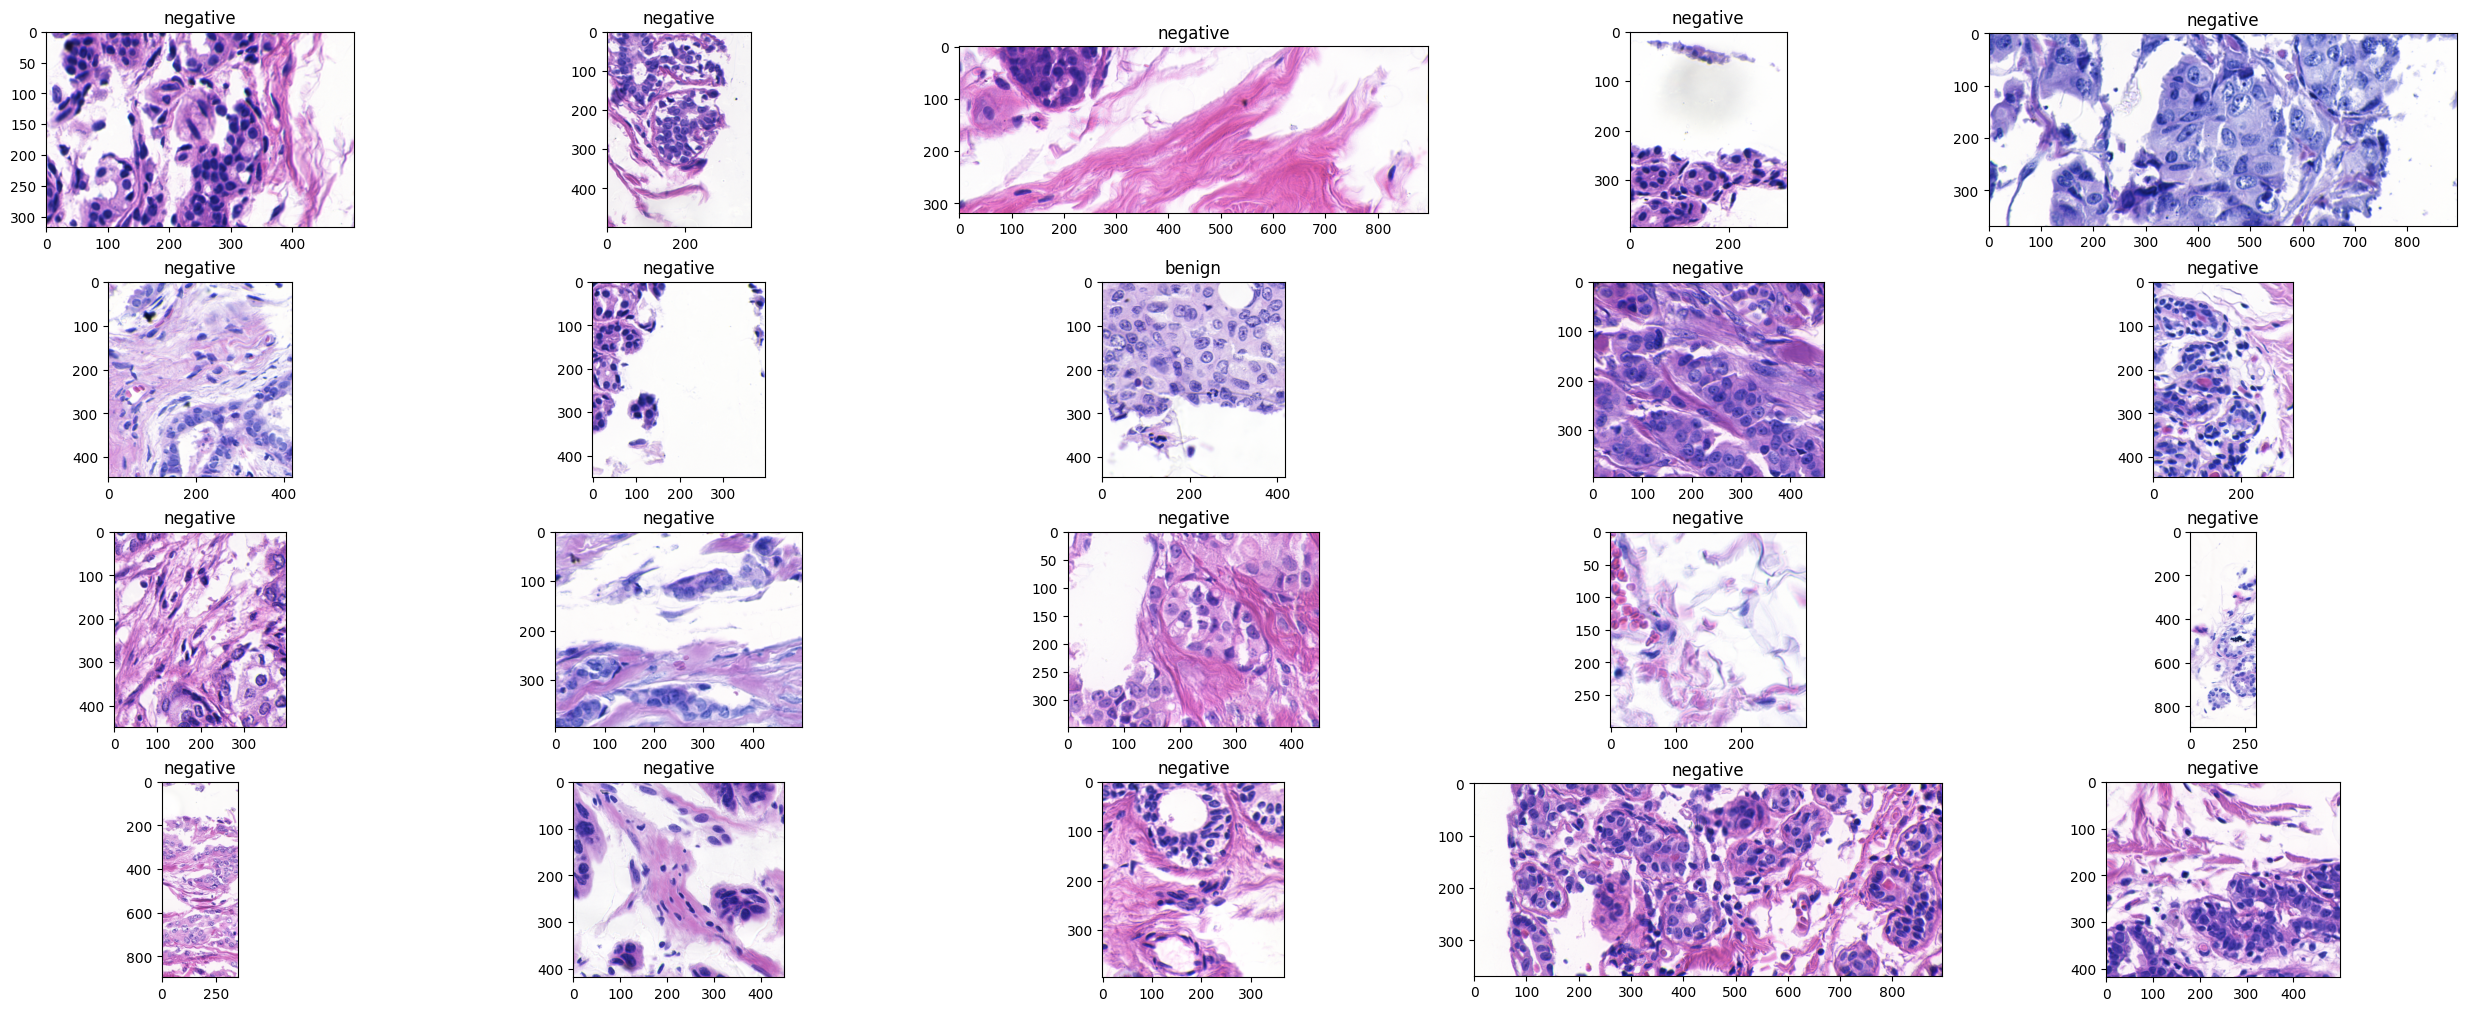

In [63]:
# Visualize some predictions

n_row, n_col = 4, 5
n_fig = n_row * n_col
fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 2.5 * n_row), constrained_layout=True)
axes = axes.flatten()
# Sample n_fig random ids
ids = np.random.choice(test_ids, size=n_fig, replace=False)
for i, id_ in enumerate(ids):
    axes[i].imshow(id2arr(id_))
    axes[i].set_title(label2text[test_labels[test_labels["id"] == id_]["malignant"].item()]);